# CNN

In [2]:
import numpy as np
from abc import ABCMeta, abstractmethod


class MLPLayer(metaclass=ABCMeta):
    @abstractmethod
    def forward(self):
        pass
    
    @abstractmethod
    def backward(self):
        pass


class CNNLayer(MLPLayer, metaclass=ABCMeta):
    def im2col(self, img, FH, FW, stride, pad):
        N, C, H, W = img.shape
        #FN, C, FH, FW = filters.shape
        # フィルタ適用後のimageサイズ
        OH = (H + 2*pad - FH) // stride + 1
        OW = (W + 2*pad - FW) // stride + 1
        img_padded = np.pad(img, [(0, 0), (0, 0), (pad, pad), (pad, pad)], 'constant')
        col = np.zeros((N, C, FH, FW, OH, OW))
        for y in range(FH):
            ymax = y + stride * OH
            for x in range(FW):
                xmax = x + stride * OW
                col[:, :, y, x, :, :] = img_padded[:, :, y:ymax:stride, x:xmax:stride]
        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*OH*OW, -1)
        return col
    
    def col2im(self, col, img_shape, FH, FW, stride, pad):
        N, C, H, W = img_shape
        #FN, C, FH, FW = filters.shape
        OH = (H + 2*pad - FH) // stride + 1
        OW = (W + 2*pad - FW) // stride + 1
        
        col_reshaped = col.reshape(N, OH, OW, C, FH, FW).transpose(0, 3, 4, 5, 1, 2)
        
        img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
        
        for y in range(FH):
            ymax = y + stride * OH
            for x in range(FW):
                xmax = x + stride * OW
                img[:, :, y:ymax:stride, x:xmax:stride] += col_reshaped[:, :, y, x, :, :]
        img = img[:, :, pad:pad+H, pad:pad+W]
        return img
        

class Convolution(CNNLayer):
    """
    Attributes
    ----------
    filters : numpy array (FN, C, FH, FW)
        FN : 出力チャンネル数
        C  : 入力チャンネル数
        FH : フィルタの行数
        FW : フィルタの列数
    bias : numpy array
    stride : 
    pad : 
    """
    def __init__(self, filters, bias, stride=1, pad=0):
        self.filters = filters
        self.bias = bias
        self.stride = stride
        self.pad = pad
        self.dF = None
        self.db = None
        self.img = None
        self.col_img = None
        self.col_filters = None
    
    def forward(self, img):
        FN, C, FH, FW = self.filters.shape
        N, C, H, W = img.shape
        #H, W = H + self.pad * 2, W + self.pad * 2
        
        col_img = self.im2col(img, FH, FW, stride=self.stride, pad=self.pad).T
        col_filters = self.filters.reshape(FN, -1)
        
        OH = (H + self.pad * 2 - FH) // self.stride + 1
        OW = (W + self.pad * 2 - FW) // self.stride + 1
        
        if (OH - 1) * self.stride - self.pad * 2 + FH != H or (OW - 1) * self.stride - self.pad * 2 + FW != W:
            raise Exception('ストライド幅が不適')
        
        self.img = img
        self.col_img = col_img
        self.col_filters = col_filters
        
        out = (np.dot(col_filters, col_img).T + self.bias).T
        out = out.reshape(FN, N, OH, OW).transpose(1, 0, 2, 3)
        return out
    
    def backward(self, dout):
        FN, C, FH, FW = self.filters.shape
        #N, C, H, W = dout.shape
        
        dout_reshaped = dout.transpose(0,2,3,1).reshape(-1, FN) # N, H, W, C
        self.db = dout_reshaped.sum(axis=0)
        self.dF = np.dot(self.col_img, dout_reshaped).T.reshape(FN, C, FH, FW)
        
        dcol = np.dot(dout_reshaped, self.col_filters)
        
        dimg = self.col2im(dcol, self.img.shape, FH, FW, self.stride, self.pad)
        
        return dimg


class MaxPooling(CNNLayer):
    def __init__(self, PH, PW, stride=1, pad=0):
        self.PH = PH
        self.PW = PW
        self.stride = stride
        self.pad = pad
        self.img = None
        self.max_args = None
    
    def forward(self, img):
        N, C, H, W = img.shape
        OH = (H + self.pad * 2 - self.PH) // self.stride + 1
        OW = (W + self.pad * 2 - self.PW) // self.stride + 1
        
        col_img = self.im2col(img, self.PH, self.PW, self.stride, self.pad).reshape(-1, self.PH*self.PW)
        max_args = col_img.argmax(axis=1)
        out = col_img.max(axis=1).reshape(N, OH, OW, C).transpose(0, 3, 1, 2)
        
        self.img = img
        self.max_args = max_args
        
        return out
    
    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)  # N, H, W, C
        
        pool_size = self.PH * self.PW
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.max_args.size), self.max_args.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dimg = self.col2im(dcol, self.img.shape, self.PH, self.PW, self.stride, self.pad)
        
        return dimg


class Image2Matrix(MLPLayer):
    def __init__(self):
        self.img_shape = None
    
    def forward(self, img):
        """
        (N, C, H, W) -> (N, C*H*W) -> (C*H*W, N)
        """
        self.img_shape = img.shape
        out = img.reshape(self.img_shape[0], -1).T
        return out
    
    def backward(self, dout):
        """
        (C*H*W, N) -> (N, C*H*W) -> (N, C, H, W)
        """
        dimg = dout.T.reshape(self.img_shape)
        return dimg


class Affine(MLPLayer):
    def __init__(self, W):
        self.W = W
        self.dW = None
        self.A_with_bias = None

    def forward(self, A):
        self.A_with_bias = np.full((A.shape[0]+1, A.shape[1]), 1.0)
        self.A_with_bias[1:] = A
        out = np.dot(self.W, self.A_with_bias)
        return out

    def backward(self, dout):
        dA = np.dot(self.W.T[1:], dout)
        self.dW = np.dot(dout, self.A_with_bias.T)
        return dA


class ReLU(MLPLayer):
    def __init__(self):
        self.mask = None
    
    def forward(self, Z):
        self.mask = Z <= 0
        out = Z.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dout):
        dphi = np.full(self.mask.shape, 1.0)
        dphi[self.mask] = 0
        dZ = dout * dphi
        return dZ


class SoftMax(MLPLayer):
    def __init__(self):
        self.Y = None
    
    def forward(self, Z):
        Z_exp = np.exp(Z)
        self.Y = Z_exp / Z_exp.sum(axis=0)
        return self.Y
    
    def backward(self, dout):
        dZ = self.Y * (dout - np.sum(self.Y * dout, axis=0))
        return dZ


class CostCalculation(MLPLayer):
    def __init__(self):
        self.Y_predict = None
        self.Y_correct = None
    
    def forward(self, Y_predict, Y_correct):
        self.Y_predict = Y_predict
        self.Y_correct = Y_correct
        cost = - np.sum(Y_correct * np.log(Y_predict) + (1.0 - Y_correct) * np.log(1.0 - Y_predict), axis=0)
        cost = np.average(cost)
        return cost
    
    def backward(self, dout=1.0):
        batch_size = self.Y_predict.shape[1]
        dA = (self.Y_predict - self.Y_correct) / (self.Y_predict * (1.0 - self.Y_predict)) / batch_size
        return dA

In [3]:
import numpy
from datetime import datetime

class CNN:
    def __init__(self, FN, FH, FW, PH, PW, h_units, epochs, eta, n_batch, stride_filter=1, pad_filter=0, stride_pool=1, pad_pool=0):
        self.eta = eta
        self.epochs = epochs
        self.n_batch = n_batch
        self.FN = FN
        self.FH = FH
        self.FW = FW
        self.stride_filter = stride_filter
        self.pad_filter = pad_filter
        self.PH = PH
        self.PW = PW
        self.stride_pool = stride_pool
        self.pad_pool = pad_pool
        self.h_units = h_units
        self.cost = None
    
    def predict(self, data):
        out = data.copy()
        for layer in self.layers:
            out = layer.forward(out)
        i_label = np.argmax(out, axis=0)
        return self.index2label[i_label]
    
    def fit(self, data_train, labels_train, data_test, labels_test):
        """
        Parameters
        ----------
        data : numpy array (N, C, H, W)
            入力画像データ
            - N : データ件数
            - C : 画像のチャンネル数
            - H : 画像の高さ（行数）
            - W : 画像の幅（列数）
        """
        N, C, H, W = data_train.shape
        N_test = len(labels_test)
        
        self.index2label = np.unique(labels_train)
        self.label2index = {self.index2label[i]: i for i in range(len(self.index2label))}
        T = len(self.index2label)
        
        Y = np.zeros([T, N])
        for i in range(N):
            l = labels_train[i]
            Y[self.label2index[l]][i] = 1.0
        Y_test = np.zeros([T, N_test])
        for i in range(N_test):
            l = labels_test[i]
            Y_test[self.label2index[l]][i] = 1.0
        
        OH = (H + self.pad_filter * 2 - self.FH) // self.stride_filter + 1
        OH = (OH + self.pad_pool * 2 - self.PH) // self.stride_pool + 1
        OW = (W + self.pad_filter * 2 - self.FW) // self.stride_filter + 1
        OW = (OW + self.pad_pool * 2 - self.PW) // self.stride_pool + 1
        
        W1 = np.random.randn(self.h_units, self.FN*OH*OW+1) * 0.01
        W2 = np.random.randn(T, self.h_units+1) * 0.01
        filters = np.random.randn(self.FN, C, self.FH, self.FW) * 0.01
        bias = np.zeros(self.FN)
        
        self.layers = [
            Convolution(filters, bias, pad=self.pad_filter, stride=self.stride_filter),
            ReLU(),
            MaxPooling(self.PH, self.PW, stride=self.stride_pool, pad=self.pad_pool),
            Image2Matrix(),
            Affine(W1),
            ReLU(),
            Affine(W2),
            SoftMax()
        ]
        self.cost_layer = CostCalculation()
        
        self.cost = []
        self.mse_train = []
        self.mse_test = []
        
        for t in range(self.epochs):
            now = datetime.now()
            print('epoch {} --- {}'.format(t+1, now.strftime('%Y/%m/%d %H:%M:%S')))
            max_iteration = max(N//self.n_batch, 1)
            for i in range(max_iteration):
                ids = np.random.choice(range(N), self.n_batch, replace=False)
                X_part = data_train[ids]
                Y_part = Y[:, ids]
                
                out = X_part
                for layer in self.layers:
                    out = layer.forward(out)
                
                cost = self.cost_layer.forward(out, Y_part)
                if i == max_iteration - 1:
                    self.cost.append(cost)
                
                dout = self.cost_layer.backward()
                dx = dout.copy()
                for layer in reversed(self.layers):
                    dx = layer.backward(dx)
        
                self.__update()
            
            # 評価
            ids_eval = np.random.choice(range(N), N_test, replace=False)
            Y_pred_train = data_train[ids_eval]
            for layer in self.layers:
                Y_pred_train = layer.forward(Y_pred_train)
            Y_pred_test = data_test.copy()
            for layer in self.layers:
                Y_pred_test = layer.forward(Y_pred_test)
            self.mse_train.append(self.__calc_mse(Y[:, ids_eval], Y_pred_train))
            self.mse_test.append(self.__calc_mse(Y_test, Y_pred_test))
        
    def __update(self):
        for layer in self.layers:
            if isinstance(layer, Affine):
                layer.W -= self.eta * layer.dW
            #elif isinstance(layer, BatchNormalization):
            #    layer.gamma -= self.eta * layer.dgamma.sum()
            #    layer.beta -= self.eta * layer.dbeta.sum()
            elif isinstance(layer, Convolution):
                layer.filters -= self.eta * layer.dF
                layer.bias -= self.eta * layer.db
    
    def __calc_mse(self, Y, Y_pred):
        return np.average(((Y-Y_pred)**2).sum(axis=0))

In [4]:
data = []
labels = []

def load_data(filename):
    data = []
    labels = []
    with open(filename) as f:
        lines = f.readlines()
        h, w = lines[0].split(',')
        h, w = int(h), int(w)
        for l in lines[1:]:
            arr = l.split(',')
            labels.append(arr[0])
            data.append([float(v) for v in arr[1:]])
        data = np.array(data).reshape(-1, 1, h, w)
        labels = np.array(labels)
    return data, labels

data_train, labels_train = load_data('../data/mnist_train')
data_test, labels_test = load_data('../data/mnist_test')

# 時間がかかる場合はこちらの小さい方のデータを使う
data_train_s, labels_train_s = data_train[:5000], labels_train[:5000]
data_test_s, labels_test_s = data_test[:1000], labels_test[:1000]

epoch 1 --- 2020/06/17 21:09:28
epoch 2 --- 2020/06/17 21:09:35
epoch 3 --- 2020/06/17 21:09:43
epoch 4 --- 2020/06/17 21:09:50
epoch 5 --- 2020/06/17 21:09:57
epoch 6 --- 2020/06/17 21:10:03
epoch 7 --- 2020/06/17 21:10:10
epoch 8 --- 2020/06/17 21:10:17
epoch 9 --- 2020/06/17 21:10:24
epoch 10 --- 2020/06/17 21:10:32
epoch 11 --- 2020/06/17 21:10:40
epoch 12 --- 2020/06/17 21:10:47
epoch 13 --- 2020/06/17 21:10:55
epoch 14 --- 2020/06/17 21:11:02
epoch 15 --- 2020/06/17 21:11:09
epoch 16 --- 2020/06/17 21:11:16
epoch 17 --- 2020/06/17 21:11:24
epoch 18 --- 2020/06/17 21:11:31
epoch 19 --- 2020/06/17 21:11:38
epoch 20 --- 2020/06/17 21:11:45


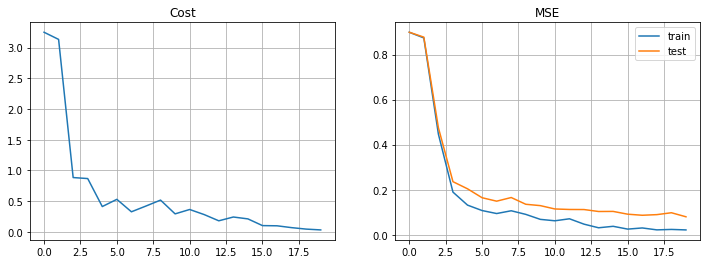

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,7,2,1,0,4,1,4,9,6,9,0,6,9,0,1,5,9,7,3,4
1,7,2,1,0,4,1,4,9,5,9,0,6,9,0,1,5,9,7,3,4
2,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True


In [28]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

cnn = CNN(FN=30, FH=5, FW=5, PH=2, PW=2, h_units=100, epochs=20, eta=1e-1, n_batch=100,
          stride_filter=1, pad_filter=0, stride_pool=2, pad_pool=0)

#cnn.fit(data_train, labels_train, data_test, labels_test)  # 1エポックに1分強かかる
cnn.fit(data_train_s, labels_train_s, data_test_s, labels_test_s)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('Cost')
plt.plot(range(len(cnn.cost)), cnn.cost)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('MSE')
plt.plot(range(len(cnn.mse_train)), cnn.mse_train, label='train')
plt.plot(range(len(cnn.mse_test)), cnn.mse_test, label='test')
plt.grid()
plt.legend()
plt.show()

pd.DataFrame([
    cnn.predict(data_test[:20]),
    labels_test[:20],
    cnn.predict(data_test[:20]) == labels_test[:20]
])

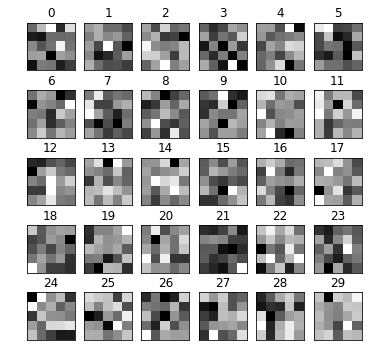

epoch 1 --- 2020/06/17 21:06:12
epoch 2 --- 2020/06/17 21:06:19
epoch 3 --- 2020/06/17 21:06:26
epoch 4 --- 2020/06/17 21:06:33
epoch 5 --- 2020/06/17 21:06:39
epoch 6 --- 2020/06/17 21:06:46
epoch 7 --- 2020/06/17 21:06:53
epoch 8 --- 2020/06/17 21:07:00
epoch 9 --- 2020/06/17 21:07:07
epoch 10 --- 2020/06/17 21:07:14
epoch 11 --- 2020/06/17 21:07:21
epoch 12 --- 2020/06/17 21:07:28
epoch 13 --- 2020/06/17 21:07:35
epoch 14 --- 2020/06/17 21:07:42
epoch 15 --- 2020/06/17 21:07:49
epoch 16 --- 2020/06/17 21:07:55
epoch 17 --- 2020/06/17 21:08:03
epoch 18 --- 2020/06/17 21:08:10
epoch 19 --- 2020/06/17 21:08:16
epoch 20 --- 2020/06/17 21:08:23


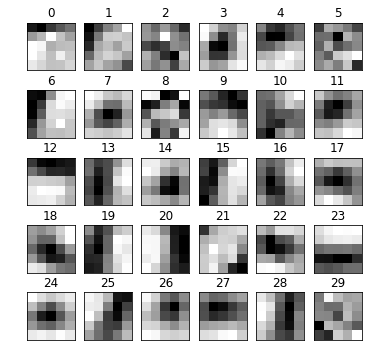

In [24]:
%matplotlib inline
from matplotlib import pyplot as plt

cnn = CNN(FN=30, FH=5, FW=5, PH=2, PW=2, h_units=100, epochs=0, eta=1e-1, n_batch=100,
          stride_filter=1, pad_filter=0, stride_pool=2, pad_pool=0)
cnn.fit(data_train_s, labels_train_s, data_test_s, labels_test_s)

plt.figure(figsize=(6, 6))
for i in range(cnn.FN):
    plt.subplot(cnn.FN//6, 6, i+1)
    plt.title(i)
    plt.xticks(color="None")
    plt.yticks(color="None")
    plt.tick_params(length=0)
    plt.imshow(cnn.layers[0].filters[i][0], cmap='binary')
plt.show()


cnn = CNN(FN=30, FH=5, FW=5, PH=2, PW=2, h_units=100, epochs=20, eta=1e-1, n_batch=100,
          stride_filter=1, pad_filter=0, stride_pool=2, pad_pool=0)
cnn.fit(data_train_s, labels_train_s, data_test_s, labels_test_s)

plt.figure(figsize=(6, 6))
for i in range(cnn.FN):
    plt.subplot(cnn.FN//6, 6, i+1)
    plt.title(i)
    plt.xticks(color="None")
    plt.yticks(color="None")
    plt.tick_params(length=0)
    plt.imshow(cnn.layers[0].filters[i][0], cmap='binary')
plt.show()